In [1]:
from typing import List, Dict
import os
import json
import pandas as pd

import matplotlib.pyplot as plt


from mathgap.logicalforms.logicalform import LogicalForm
from mathgap.natlang.templates.template import WHITESPACE
from mathgap.trees.generators import MultiGenerator
from mathgap.trees.sampling.order import OrderSampler
from mathgap.generation_util import *

from data.util import DATA_FOLDER

from mathgap.instantiate.instantiation import Instantiation
from mathgap.properties import PropertyKey
from mathgap.natlang.templates import WHITESPACE, render_problem
from mathgap.natlang.templates.templaterenderer import TemplateRenderer
from mathgap.data.util import load_entities
from templaterendering import interleaved_template_selections, render_interleaved, traverse_reasoning_trace_multitree, interleaved_template_selection_rt, render_interleaved_rt

from generationutil import get_next_problem


In [ ]:
min_depth = 2
max_depth = 3
data_folder = "data"
num_irrelevant_trees = 3
seed = 14

In [3]:
with open("data/entities/extended/entities_topic.json", "r") as f:
    entities_by_topic = {tuple(tdata["topic"]):[tuple(e) for e in tdata["entities"]] for tdata in json.load(f)}
    all_entities_with_topic = set([e for entities in entities_by_topic.values() for e in entities])
    
RULESET = [ContTransferCont(),
    ContCompCont(),
    ContCompCompeqCont(),
    ContContComp(),
    ContPartWhole(),
    ContRateCont()]

IRRELEVANT_RULESET = [
    ContTransferCont(),
    ContCompCont(),
    ContContComp(),
    ContPartWhole()
]

weights_by_generator_base = {
    default_generator(use_attribute=False, use_unit=False, 
                        comp_same_entity_prob=1.0, compeq_same_entity_prob=1.0,
                        stopping_criterion=BranchDepthCriterion(i), 
                        start_types=start_type, inference_rules=RULESET): 1.0
    for i in range(min_depth, max_depth+1)
    for start_type in [CONT_START_TYPE, PARTWHOLE_START_TYPE]
}
base_generator = MultiGenerator(weights_by_generator_base)

# disallow partwhole and irrelevant trees
weights_by_generator_irrelevant = {
    default_generator(use_attribute=False, use_unit=False, 
                        comp_same_entity_prob=1.0, compeq_same_entity_prob=1.0,
                        stopping_criterion=BranchDepthCriterion(i), 
                        start_types=CONT_START_TYPE, inference_rules=IRRELEVANT_RULESET): 1.0
    for i in range(min_depth, max_depth+1)
}
irrelevant_generator = MultiGenerator(weights_by_generator_irrelevant)

instantiator = default_instantiator(data_folder=data_folder, dataversion="extended", leaf_min_value=2, leaf_max_value=99, 
                                    inner_min_value=2, inner_max_value=10_000, max_attempts=1_000, strategy="cpga")

# get a list of entities that are assigned to topics
topic_entites = load_entities(data_folder=data_folder, version="extended")
topic_entites["entities_without_units"] = [e for e in topic_entites["entities_without_units"] if e in all_entities_with_topic]
topic_entites["parts_by_whole"] = {whole:[e for e in parts if e in all_entities_with_topic] for whole,parts in topic_entites["parts_by_whole"].items()}

lexical_overlaps = list(pd.read_csv(os.path.join(data_folder, "agents", "extended", "lexical_overlap.csv"), index_col=False, names=["name"])["name"])

topic_instantiator = default_instantiator(data_folder=data_folder, dataversion="extended", leaf_min_value=2, leaf_max_value=20, 
                                          inner_min_value=2, inner_max_value=1_000, entities=topic_entites, strategy="cpga")



problem_order_sampler = CanonicalOrderSampler()
template_renderer = TemplateRenderer()
ps_template_sampler, ps_answers_template_sampler, ps_renderer, rt_template_sampler, rt_renderer \
    = default_templates_and_samplers(data_folder, "extended", WHITESPACE)

In [ ]:
problem = None
while problem is None:
    seed = random.randint(0, 2**32 - 1)
    try:
        problem = get_next_problem(base_generator, irrelevant_generator, instantiator, topic_instantiator, entities_by_topic, lexical_overlaps, num_irrelevant_trees, problem_order_sampler, ps_template_sampler, ps_renderer, rt_template_sampler, rt_renderer, template_renderer, seed=seed)
    except Exception as e:
        print(e)
        if "Failed to find a valid instantiation after" in str(e): print(e)
        elif "Invalid whole <-> part mapping" in str(e): print(e)
        elif "Base tree does not have enough" in str(e): print(e)
        elif "not a valid super-entity" in str(e): print(e)
        elif "Requires at least one super-entity with sub-entity" in str(e): print(e)
        elif "Can only have one pre-instantiated part of a whole if we need to resort to whole=part" in str(e): print(e)
        elif "Cannot overwrite" in str(e): print(e)
        else: raise e

Invalid whole <-> part mapping (('toy vehicle', 'toy vehicles') <-> ('toy vehicle', 'toy vehicles')). This is likely due to partial instantiation of partwhole entities
Invalid whole <-> part mapping (('toy vehicle', 'toy vehicles') <-> ('toy vehicle', 'toy vehicles')). This is likely due to partial instantiation of partwhole entities
Requires at least one super-entity with sub-entity ('plastic bag', 'plastic bags'), as it has been pre-initialized
Requires at least one super-entity with sub-entity ('plastic bag', 'plastic bags'), as it has been pre-initialized


In [7]:
with open("datasets/500.json", "r") as f:
    dataset = json.load(f)

problem = dataset[0]

Axiom types in base-problem


(array([1529.,    0.,  956.,    0.,    0.,  610.,    0.,  255.,    0.,
         305.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

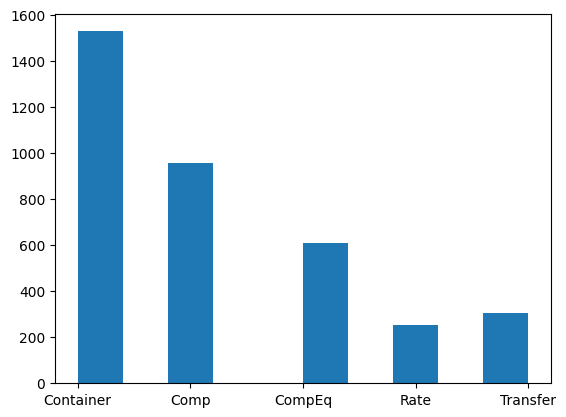

In [8]:
print("Axiom types in base-problem")
types = []
for problem in dataset:
    for s in problem["base"]["problembody"]:
        types.append(s["lf"])
plt.hist(types)


CompEq vs No-CompEq base-problems


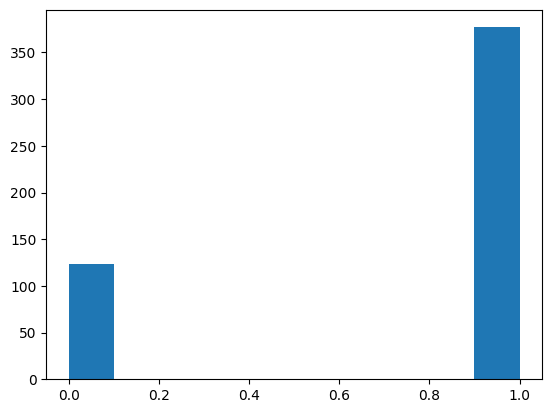

(array([ 78., 118.,  95.,  86.,  38.,  34.,  14.,  15.,  15.,   7.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <BarContainer object of 10 artists>)

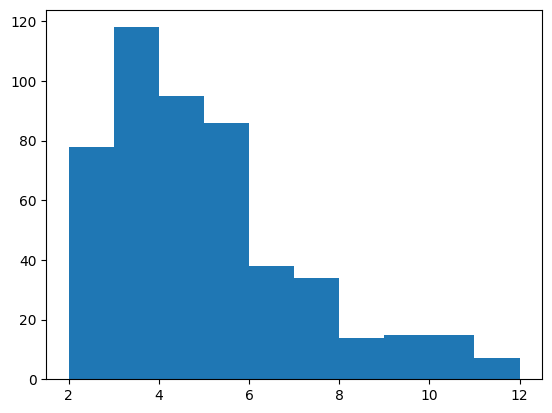

In [9]:
print("CompEq vs No-CompEq base-problems")
compeq = []
rule_counts = []
for problem in dataset:
    compeq.append(1.0 * ("ContCompCompeqCont" in problem["base"]["trees"]["base"]["rule_counts"]))
    rule_counts.append(sum(problem["base"]["trees"]["base"]["rule_counts"].values()))
plt.hist(compeq)
plt.show()
plt.hist(rule_counts)


In [7]:
print("# Axioms")
print(f'Base: problem={len(problem["base"]["problembody"])}')
for connection_type in ["connected", "disconnected"]:
    print(connection_type)
    for complexity in ["simple", "complex", "more_complex"]:
        print(f"\t{complexity}")
        for overlap in ["no_overlap", "agent_overlap", "entity_overlap", "agent_entity_overlap"]:
            print(f'\t\t{overlap}: {len(problem[connection_type][complexity][overlap]["problembody"])}')

# Axioms
Base: problem=6
connected
	simple
		no_overlap: 7
		agent_overlap: 7
		entity_overlap: 7
		agent_entity_overlap: 7
	complex
		no_overlap: 8
		agent_overlap: 8
		entity_overlap: 8
		agent_entity_overlap: 8
	more_complex
		no_overlap: 12
		agent_overlap: 12
		entity_overlap: 12
		agent_entity_overlap: 12
disconnected
	simple
		no_overlap: 7
		agent_overlap: 7
		entity_overlap: 7
		agent_entity_overlap: 7
	complex
		no_overlap: 8
		agent_overlap: 8
		entity_overlap: 8
		agent_entity_overlap: 8
	more_complex
		no_overlap: 12
		agent_overlap: 12
		entity_overlap: 12
		agent_entity_overlap: 12


In [8]:
print("Are all sentences of the problem in the reasoning trace?")
for connection_type in ["connected", "disconnected"]:
    print(connection_type)
    for complexity in ["simple", "complex", "more_complex"]:
        print(f"\t{complexity}")
        for overlap in ["no_overlap", "agent_overlap", "entity_overlap", "agent_entity_overlap"]:
            print(f'\t\t{overlap}: {all((p["text"] in [t["text"] for t in problem[connection_type][complexity][overlap]["rt"]]) for p in problem[connection_type][complexity][overlap]["problembody"])}')

Are all sentences of the problem in the reasoning trace?
connected
	simple
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True
	complex
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True
	more_complex
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True
disconnected
	simple
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True
	complex
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True
	more_complex
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True


In [9]:
# How similar are the control problems?
print("How different are control problems to the posed problems (abs diff in nr of axioms, abs diff in nr of rules)?")
def diff_control(pdata, cdata):
    diff_nr_axioms = abs(len(pdata["problembody"]) - len(cdata["problembody"]))

    irrelevant_rule_cnts = {}
    for tdata in pdata["trees"].values():
        for rule,cnt in tdata["rule_counts"].items():
            irrelevant_rule_cnts[rule] = irrelevant_rule_cnts.get(rule, 0) + cnt

    control_rule_cnts = cdata["trees"]["control"]["rule_counts"]

    diff_nr_rules = sum(abs(irrelevant_rule_cnts.get(k, 0) - control_rule_cnts.get(k, 0)) for k in set(irrelevant_rule_cnts).union(set(control_rule_cnts)))
    return diff_nr_axioms, diff_nr_rules

print("Are all sentences of the problem in the reasoning trace?")
for connection_type in ["connected", "disconnected"]:
    print(connection_type)
    for complexity in ["simple", "complex", "more_complex"]:
        print(f"\t{complexity}")
        for overlap in ["no_overlap", "agent_overlap", "entity_overlap", "agent_entity_overlap"]:
            print(f'\t\t{overlap}: {diff_control(problem[connection_type][complexity][overlap], problem[connection_type][complexity]["control"])}')

How different are control problems to the posed problems (abs diff in nr of axioms, abs diff in nr of rules)?
Are all sentences of the problem in the reasoning trace?
connected
	simple
		no_overlap: (0, 0)
		agent_overlap: (0, 0)
		entity_overlap: (0, 0)
		agent_entity_overlap: (0, 0)
	complex
		no_overlap: (0, 0)
		agent_overlap: (0, 0)
		entity_overlap: (0, 0)
		agent_entity_overlap: (0, 0)
	more_complex
		no_overlap: (0, 0)
		agent_overlap: (0, 0)
		entity_overlap: (0, 0)
		agent_entity_overlap: (0, 0)
disconnected
	simple
		no_overlap: (0, 0)
		agent_overlap: (0, 0)
		entity_overlap: (0, 0)
		agent_entity_overlap: (0, 0)
	complex
		no_overlap: (0, 1)
		agent_overlap: (0, 1)
		entity_overlap: (0, 1)
		agent_entity_overlap: (0, 1)
	more_complex
		no_overlap: (0, 3)
		agent_overlap: (0, 3)
		entity_overlap: (0, 3)
		agent_entity_overlap: (0, 3)


In [10]:
from collections import defaultdict

def remove_lex(agent_name):
    return agent_name.split("’s")[0]


def check_match_disconnected(pdata, overlap: str) -> bool:
    agents_by_tree = defaultdict(set)
    for s,a in set([(s["source"], a) for s in pdata["problembody"] for a in s["inst"]["agents"]]):
        agents_by_tree[s].add(a)

    entities_by_tree = defaultdict(set)
    for s,e in set([(s["source"], tuple(e)) for s in pdata["problembody"] for e in s["inst"]["entities"]]):
        entities_by_tree[s].add(e)

    if overlap == "agent_overlap":
        matches = True
        # all agents of the irrelevant trees should be in the base_tree (or a lexical variant thereof)...
        base_agents_no_lex = set([remove_lex(ag) for ag in agents_by_tree["base"]])
        for irrelevant_agents in [agents_by_tree.get(f"irrelevant_{i}", set()) for i in range(num_irrelevant_trees)]:
            if len(irrelevant_agents) == 0: continue # Tree likely not used
            irrelevant_agents_no_lex = set([remove_lex(ag) for ag in irrelevant_agents])
            if not irrelevant_agents_no_lex.issubset(base_agents_no_lex):
                matches = False
    elif overlap == "no_overlap":
        matches = True
        # check that no agents overlap between two trees
        for t1,as1 in agents_by_tree.items():
            for t2,as2 in agents_by_tree.items():
                if t1 == t2: 
                    continue
                elif len(set(as1).intersection(set(as2))) > 0:
                    matches = False
        # check that no entities overlap between two trees
        for t1,es1 in entities_by_tree.items():
            for t2,es2 in entities_by_tree.items():
                if t1 == t2: 
                    continue
                elif len(set(es1).intersection(set(es2))) > 0:
                    matches = False
    elif overlap == "entity_overlap":
        matches = True
        # check that no agents overlap between two trees
        for t1,as1 in agents_by_tree.items():
            for t2,as2 in agents_by_tree.items():
                if t1 == t2: 
                    continue
                elif len(set(as1).intersection(set(as2))) > 0:
                    matches = False
        # check that all entities of the irrelevant trees are also in the base_tree
        matches = matches and all(entities_by_tree.get(f"irrelevant_{i}", set()).issubset(entities_by_tree["base"]) for i in range(num_irrelevant_trees))
    elif overlap == "agent_entity_overlap":
        matches = True
        # all agents of the irrelevant trees should be in the base_tree (or a lexical variant thereof)...
        base_agents_no_lex = set([remove_lex(ag) for ag in agents_by_tree["base"]])
        for irrelevant_agents in [agents_by_tree.get(f"irrelevant_{i}", set()) for i in range(num_irrelevant_trees)]:
            if len(irrelevant_agents) == 0: continue # Tree likely not used
            irrelevant_agents_no_lex = set([remove_lex(ag) for ag in irrelevant_agents])
            if not irrelevant_agents_no_lex.issubset(base_agents_no_lex):
                matches = False

        # check that all entities of the irrelevant trees are also in the base_tree
        matches = matches and all(entities_by_tree.get(f"irrelevant_{i}", set()).issubset(entities_by_tree["base"]) for i in range(num_irrelevant_trees))
    return matches

def check_match_connected(pdata, overlap) -> bool:
    agents_by_tree = defaultdict(set)
    for s,a in set([(s["source"], a) for s in pdata["problembody"] for a in s["inst"]["agents"]]):
        agents_by_tree[s].add(a)

    entities_by_tree = defaultdict(set)
    for s,e in set([(s["source"], tuple(e)) for s in pdata["problembody"] for e in s["inst"]["entities"]]):
        entities_by_tree[s].add(e)

    matches = False
    if overlap == "agent_overlap":
        # NOTE: all agents should match and exactly one entity
        matches = True

        # all agents of the irrelevant trees should be in the base_tree (or a lexical variant thereof)...
        base_agents_no_lex = set([remove_lex(ag) for ag in agents_by_tree["base"]])
        for irrelevant_agents in [agents_by_tree.get(f"irrelevant_{i}", set()) for i in range(num_irrelevant_trees)]:
            if len(irrelevant_agents) == 0: continue # Tree likely not used
            irrelevant_agents_no_lex = set([remove_lex(ag) for ag in irrelevant_agents])
            if not irrelevant_agents_no_lex.issubset(base_agents_no_lex):
                matches = False

        # ... at least one should be a 100% match
        for irrelevant_agents in [agents_by_tree.get(f"irrelevant_{i}", set()) for i in range(num_irrelevant_trees)]:
            if len(irrelevant_agents) == 0: continue # Tree likely not used
            if len(irrelevant_agents.intersection(agents_by_tree["base"])) < 1:
                matches = False

        # each irrelevant tree should overlap with the base tree in exactly one entity
        for irrelevant_entities in [entities_by_tree.get(f"irrelevant_{i}", set()) for i in range(num_irrelevant_trees)]:
            if len(irrelevant_entities) == 0: continue # Tree likely not used
            if len(irrelevant_entities.intersection(entities_by_tree["base"])) != 1:
                matches = False
    elif overlap == "no_overlap":
        # NOTE: exactly one agent and one entity should match
        matches = True

        # each irrelevant tree should overlap with the base tree in exactly one agent
        for irrelevant_agents in [agents_by_tree.get(f"irrelevant_{i}", set()) for i in range(num_irrelevant_trees)]:
            if len(irrelevant_agents) == 0: continue # Tree likely not used
            if len(irrelevant_agents.intersection(agents_by_tree["base"])) != 1:
                matches = False

        # each irrelevant tree should overlap with the base tree in exactly one entity
        for irrelevant_entities in [entities_by_tree.get(f"irrelevant_{i}", set()) for i in range(num_irrelevant_trees)]:
            if len(irrelevant_entities) == 0: continue # Tree likely not used
            if len(irrelevant_entities.intersection(entities_by_tree["base"])) != 1:
                matches = False
    elif overlap == "entity_overlap":
        # NOTE: all entities should match and exactly one agent
        matches = True
        
        # check that all entities of the irrelevant trees are also in the base_tree
        matches = matches and all(entities_by_tree.get(f"irrelevant_{i}", set()).issubset(entities_by_tree["base"]) for i in range(num_irrelevant_trees))

        # each irrelevant tree should overlap with the base tree in exactly one agent
        for irrelevant_agents in [agents_by_tree.get(f"irrelevant_{i}", set()) for i in range(num_irrelevant_trees)]:
            if len(irrelevant_agents) == 0: continue # Tree likely not used
            if len(irrelevant_agents.intersection(agents_by_tree["base"])) != 1:
                matches = False

    elif overlap == "agent_entity_overlap":
        # NOTE: all agents and all entities should match
        matches = True
        
        # all agents of the irrelevant trees should be in the base_tree (or a lexical variant thereof)...
        base_agents_no_lex = set([ag.split("’s")[0] for ag in agents_by_tree["base"]])
        for irrelevant_agents in [agents_by_tree.get(f"irrelevant_{i}", set()) for i in range(num_irrelevant_trees)]:
            if len(irrelevant_agents) == 0: continue # Tree likely not used
            irrelevant_agents_no_lex = set([ag.split("’s")[0] for ag in irrelevant_agents])
            if not irrelevant_agents_no_lex.issubset(base_agents_no_lex):
                matches = False

        # ... at least one should be a 100% match
        for irrelevant_agents in [agents_by_tree.get(f"irrelevant_{i}", set()) for i in range(num_irrelevant_trees)]:
            if len(irrelevant_agents) == 0: continue # Tree likely not used
            if len(irrelevant_agents.intersection(agents_by_tree["base"])) < 1:
                matches = False

        # check that all entities of the irrelevant trees are also in the base_tree
        matches = matches and all(entities_by_tree.get(f"irrelevant_{i}", set()).issubset(entities_by_tree["base"]) for i in range(num_irrelevant_trees))
    return matches

In [11]:
print("Do all irrelevant trees overlap correctly with the base tree?")

print("connected")
for complexity in ["simple", "complex", "more_complex"]:
    print(f"\t{complexity}")
    for overlap in ["no_overlap", "agent_overlap", "entity_overlap", "agent_entity_overlap"]:
        print(f'\t\t{overlap}: {check_match_connected(problem["connected"][complexity][overlap], overlap)}')

print("disconnected")
for complexity in ["simple", "complex", "more_complex"]:
    print(f"\t{complexity}")
    for overlap in ["no_overlap", "agent_overlap", "entity_overlap", "agent_entity_overlap"]:
        print(f'\t\t{overlap}: {check_match_disconnected(problem["disconnected"][complexity][overlap], overlap)}')

Do all irrelevant trees overlap correctly with the base tree?
connected
	simple
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True
	complex
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True
	more_complex
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True
disconnected
	simple
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True
	complex
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True
	more_complex
		no_overlap: True
		agent_overlap: True
		entity_overlap: True
		agent_entity_overlap: True


In [12]:
print("Inspect the agents and entities used by each tree")
pdata = problem["connected"]["more_complex"]["agent_entity_overlap"]
print("Question: " + pdata["question"]["text"])

agents_by_tree = defaultdict(set)
for s,a in set([(s["source"], a) for s in pdata["problembody"] for a in s["inst"]["agents"]]):
    agents_by_tree[s].add(a)

for s,a in set([("control", a) for s in pdata["control"]["problembody"] for a in s["inst"]["agents"]]):
    agents_by_tree[s].add(a)

entities_by_tree = defaultdict(set)
for s,e in set([(s["source"], tuple(e)) for s in pdata["problembody"] for e in s["inst"]["entities"]]):
    entities_by_tree[s].add(e)

for s,e in set([("control", tuple(e)) for s in pdata["control"]["problembody"] for e in s["inst"]["entities"]]):
    entities_by_tree[s].add(e)

agents_by_tree, entities_by_tree

Inspect the agents and entities used by each tree
Question: If Riordan, Melvyn and Jory sum up the snacks that they have, how many snacks do they have in total?


KeyError: 'control'

In [13]:
connection_type = "connected"
complexity = "more_complex"
overlap = "agent_entity_overlap"

pdata = problem[connection_type][complexity][overlap]
print(f"Setting: {connection_type}, {complexity}, {overlap}\n")

print("Disentangled Problem:")
for sid,sent in enumerate(pdata['problembody'] + [pdata["question"]]):
    print(f"{sid}. {sent['source']}\n \t {sent['text']}")

print("\n\n")
print("-"*100)
print("\n\n")

print("Disentangled RT:")
for sid,sent in enumerate(pdata['rt']):
    print(f"{sid}. {sent['source'], sent['premise_sent_indices']}\n \t {sent['text']}")


Setting: connected, more_complex, agent_entity_overlap

Disentangled Problem:
0. base
 	 Ritchie has 16 granola bars.
1. base
 	 Riordan has 5 granola bars less than Ritchie.
2. irrelevant_0
 	 Melvyn’s teacher has 3 granola bars less than Ritchie.
3. irrelevant_0
 	 Melvyn’s teacher then gives Jory’s mother 8 granola bars.
4. base
 	 Mendel possesses 6 biscuits.
5. base
 	 Mendel has 9 biscuits fewer than Melvyn.
6. base
 	 Jose has 4 donuts.
7. irrelevant_2
 	 Jory’s daughter has 2 biscuits less than Mendel.
8. base
 	 Jose has 13 donuts less than Jory.
9. irrelevant_2
 	 Jory’s daughter then gives Riordan’s uncle 2 biscuits.
10. irrelevant_1
 	 Melvyn’s boss has 6 donuts less than Jory.
11. irrelevant_1
 	 Melvyn’s boss then gives Melvyn’s doctor 3 donuts.
12. base
 	 If Riordan, Melvyn and Jory sum up the snacks that they have, how many snacks do they have in total?



----------------------------------------------------------------------------------------------------



Disentangl

In [14]:
connection_type = "disconnected"
complexity = "more_complex"
overlap = "agent_overlap"

pdata = problem[connection_type][complexity][overlap]
print(f"Setting: {connection_type}, {complexity}, {overlap}\n")

print("Disentangled Problem:")
for sid,sent in enumerate(pdata['problembody'] + [pdata["question"]]):
    print(f"{sid}. {sent['source']}\n \t {sent['text']}")

print("\n\n")
print("-"*100)
print("\n\n")

print("Disentangled RT:")
for sid,sent in enumerate(pdata['rt']):
    print(f"{sid}. {sent['source'], sent['premise_sent_indices']}\n \t {sent['text']}")


Setting: disconnected, more_complex, agent_overlap

Disentangled Problem:
0. base
 	 Ritchie has 16 granola bars.
1. irrelevant_1
 	 Melvyn’s assistant has 90 rice cakes.
2. base
 	 Riordan has 5 granola bars less than Ritchie.
3. irrelevant_0
 	 Jory’s teacher has 61 pretzels.
4. base
 	 Mendel owns 6 biscuits.
5. base
 	 Mendel has 9 biscuits less than Melvyn.
6. base
 	 Jose has 4 donuts.
7. irrelevant_2
 	 Jory’s aunt has 48 croissants.
8. irrelevant_2
 	 Jory’s aunt then gives Riordan’s neighbor 15 croissants.
9. irrelevant_1
 	 Melvyn’s assistant then gives Jory’s brother 21 rice cakes.
10. irrelevant_0
 	 Jory’s teacher then gives Jory’s coworker 2 pretzels.
11. base
 	 Jose has 13 donuts fewer than Jory.
12. base
 	 If Riordan, Melvyn and Jory sum up the snacks that they have, how many snacks do they have combined?



----------------------------------------------------------------------------------------------------



Disentangled RT:
0. ('base', [])
 	 Ritchie has 16 granola

In [6]:
# Generate dataset
import json
dataset = []
num_problems = 500
while len(dataset) < num_problems:
    if len(dataset) % 25 == 0: 
        print(f"#{len(dataset)}")
    seed = random.randint(0, 2**32-1)
    try:
        dataset.append(get_next_problem(base_generator, irrelevant_generator, instantiator, topic_instantiator, entities_by_topic, lexical_overlaps, num_irrelevant_trees, problem_order_sampler, ps_template_sampler, ps_renderer, rt_template_sampler, rt_renderer, template_renderer, seed=seed))
    except Exception as e:
        print(e)

with open(f"datasets/{num_problems}.json", "w+") as f:
    json.dump(dataset, f)

#0
Failed to find a valid instantiation after 1000 iterations!
Can only have one pre-instantiated part of a whole if we need to resort to whole=part, but got {('parrot', 'parrots'), ('chair', 'chairs')}
Failed to find a valid instantiation after 1000 iterations!
Failed to find a valid instantiation after 1000 iterations!
Failed to find a valid instantiation after 1000 iterations!
Can only have one pre-instantiated part of a whole if we need to resort to whole=part, but got {('violin', 'violins'), ('eggplant', 'eggplants'), ('eraser', 'erasers')}
Failed to find a valid instantiation after 1000 iterations!
Failed to find a valid instantiation after 1000 iterations!
Failed to find a valid instantiation after 1000 iterations!
Failed to find a valid instantiation after 1000 iterations!
Can only have one pre-instantiated part of a whole if we need to resort to whole=part, but got {('granola bar', 'granola bars'), ('table', 'tables')}
Can only have one pre-instantiated part of a whole if we n